# Imports

In [1]:
import pandas as pd
import numpy as np
import string
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# Loadind Data

In [ ]:
df = pd.read_csv("pub_abs.csv")
abst_list = df['Abstract'].values.astype('U')

In [2]:
df = pd.read_csv("people_wiki.csv")
abst_list = df['text'].values.astype('U')

# Text Preprocessing

In [ ]:
#preprocessing for pubmed data
nopunc = str.maketrans('', '', string.punctuation)
lem = WordNetLemmatizer()
custom_stopwords = set(stopwords.words("english")+ ["study", "group", "patient", "used", 
                                                     "disease", "effect", "method", "also",
                                                     "result", "two", "may","level",
                                                     "participant","treatment","associated"
                                                     "risk", "however","year",
                                                     "the", "this","using", "showed", "analysis"])
custom_stopwords = [lem.lemmatize(word) for word in custom_stopwords]

In [3]:
#preprocessing for wiki people data
nopunc = str.maketrans('', '', string.punctuation)
lem = WordNetLemmatizer()
custom_stopwords = set(stopwords.words("english")+ ["study", "year", "president", "book", 
                                                     "state", "work", "first", "also",
                                                     "united", "member", "served","university","the"])
custom_stopwords = [lem.lemmatize(word) for word in custom_stopwords]

In [4]:
def preprocess(abst_list):
    abstracts =[]
    for line in abst_list:
        line.replace("\n", "")
        line = line.lower()
        line = line.translate(nopunc)
        line = re.sub('[^A-Za-z]', ' ', line)
        new = ' '
        for word in line.split():
            word = lem.lemmatize(word)
            if word not in custom_stopwords and len(word)>3:
                new = new + ' ' + word
        abstracts.append(new)
    return abstracts

In [5]:
abstract_list = preprocess(abst_list)

In [ ]:
abstract_list[0]

In [6]:
def tokenizer(abst_list):
    abstract_tokens =[]
    for line in abst_list:
        tokens = word_tokenize(line)
        tokens = [t for t in tokens if len(t) > 3]
        abstract_tokens.append(tokens)
    return abstract_tokens

In [7]:
abstract_tokens = tokenizer(abstract_list)

# Word Vectorization

In [8]:
vectorizer = KeyedVectors.load_word2vec_format('word2vec_embedding.bin', binary=True)

In [9]:
def w2v_vectorizer(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [10]:
text_vectors = w2v_vectorizer(abstract_tokens,vectorizer)

# Model building

In [11]:
# checking for optimal number of clusters
sse = []
list_k = list(range(2,15))

for k in list_k:
    km = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
    km.fit(text_vectors)
    sse.append(km.inertia_)
    


In [12]:
k = 6
k_means = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
k_means.fit(text_vectors)

MiniBatchKMeans(max_iter=1000, n_clusters=6, n_init=20, random_state=0)

# visualization

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=0)
reduced_vectors = pca.fit_transform(text_vectors)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

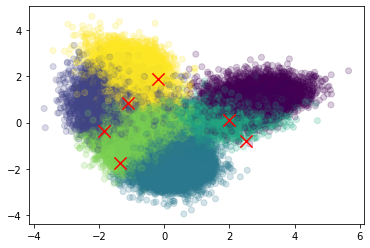

In [14]:
plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_, alpha=0.2)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

# Top words from each cluster

In [ ]:
df['preprocessed_abstract'] = abstract_list
df['labels'] = k_means.labels_
df['labels'].value_counts()

In [ ]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def get_wordcloud(text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
from wordcloud import WordCloud
for clus in range (6):
    text =' '
    df2 = df.loc[df["labels"]==clus]
    
    #wordcloud
    for abst in df2.preprocessed_abstract:
        text += abst
    get_wordcloud(text)
    
    #top10words
    words = []
    for i, j in get_top_n_words(df2["preprocessed_abstract"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)